这个是深度学习课后的小作业，主要是给大家再熟悉一下模型训练的流程，让大家体验一下。我们这里的任务是对10个类别的“时装”图像进行分类，使用[FashionMNIST数据集](https://github.com/zalandoresearch/fashion-mnist/tree/master/data/fashion )。 
FashionMNIST数据集中包含已经预先划分好的训练集和测试集，其中训练集共60,000张图像，测试集共10,000张图像。每张图像均为单通道黑白图像，大小为28\*28pixel，分属10个类别。  

**首先导入必要的包** 

In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

**配置训练环境和超参数** 

In [7]:
# 配置GPU，这里有两种方式
## 方案一：使用os.environ
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# 方案二：使用“device”，后续对要使用GPU的变量用.to(device)即可
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## 配置其他超参数，如batch_size, num_workers, learning rate, 以及总的epochs
batch_size = 256
num_workers = 0   # 对于Windows用户，这里应设置为0，否则会出现多线程错误
lr = 1e-4
epochs = 20

**数据读入和加载**  
这里同时展示两种方式:  
- 下载并使用PyTorch提供的内置数据集  
- 从网站下载以csv格式存储的数据，读入并转成预期的格式    
第一种数据读入方式只适用于常见的数据集，如MNIST，CIFAR10等，PyTorch官方提供了数据下载。这种方式往往适用于快速测试方法（比如测试下某个idea在MNIST数据集上是否有效）  
第二种数据读入方式需要自己构建Dataset，这对于PyTorch应用于自己的工作中十分重要  
  
同时，还需要对数据进行必要的变换，比如说需要将图片统一为一致的大小，以便后续能够输入网络训练；需要将数据格式转为Tensor类，等等。
  
**我们实际比赛的时候数据加载和处理是一个非常关键的步骤。**

In [8]:
# 首先设置数据变换
from torchvision import transforms

image_size = 28
data_transform = transforms.Compose([
    transforms.ToPILImage(),  
     # 这一步取决于后续的数据读取方式，如果使用内置数据集读取方式则不需要
    transforms.Resize(image_size),
    transforms.ToTensor()
])

In [9]:
## 读取方式一：使用torchvision自带数据集，下载可能需要一段时间
# from torchvision import datasets

# train_data = datasets.FashionMNIST(root='./', train=True, download=True, transform=data_transform)
# test_data = datasets.FashionMNIST(root='./', train=False, download=True, transform=data_transform)

In [10]:
## 读取方式二：读入csv格式的数据，自行构建Dataset类
# csv数据下载链接：https://www.kaggle.com/zalando-research/fashionmnist
class FMDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform
        self.images = df.iloc[:,1:].values.astype(np.uint8)
        self.labels = df.iloc[:, 0].values
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        image = self.images[idx].reshape(28,28,1)
        label = int(self.labels[idx])
        if self.transform is not None:
            image = self.transform(image)
        else:
            image = torch.tensor(image/255., dtype=torch.float)
        label = torch.tensor(label, dtype=torch.long)
        return image, label

train_df = pd.read_csv("./fashion-mnist_train.csv")
test_df = pd.read_csv("./fashion-mnist_test.csv")
train_data = FMDataset(train_df, data_transform)
test_data = FMDataset(test_df, data_transform)

在构建训练和测试数据集完成后，需要定义DataLoader类，以便在训练和测试时加载数据  

In [11]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

读入后，我们可以做一些数据可视化操作，主要是验证我们读入的数据是否正确

torch.Size([256, 1, 28, 28]) torch.Size([256])


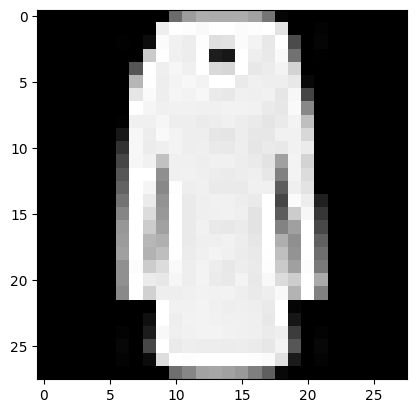

In [12]:
import matplotlib.pyplot as plt
image, label = next(iter(train_loader))
print(image.shape, label.shape)
plt.imshow(image[0][0], cmap="gray")

**模型设计**  
由于任务较为简单，这里我们手搭一个CNN，而不考虑当下各种模型的复杂结构，模型构建完成后，将模型放到GPU上用于训练。  

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3),
            nn.Conv2d(32, 64, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, stride=2),
            nn.Dropout(0.3)
        )
        self.fc = nn.Sequential(
            nn.Linear(64*4*4, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*4*4)
        x = self.fc(x)
        # x = nn.functional.normalize(x)
        return x

model = Net()
model = model.cuda()
# model = nn.DataParallel(model).cuda()   # 多卡训练时的写法

**设定损失函数**  
使用torch.nn模块自带的CrossEntropy损失  
PyTorch会自动把整数型的label转为one-hot型，用于计算CE loss  
这里需要确保label是从0开始的，同时模型不加softmax层（使用logits计算）,这也说明了PyTorch训练中各个部分不是独立的，需要通盘考虑

In [14]:
criterion = nn.CrossEntropyLoss()
# criterion = nn.CrossEntropyLoss(weight=[1,1,1,1,3,1,1,1,1,1])

**设定优化器**  
这里我们使用Adam优化器 

In [15]:
optimizer = optim.Adam(model.parameters(), lr=0.001)

**训练流程（自己写）**
调⽤model.train()
(1) 从train_dataloader中加载数据
(2) 计算损失函数
(3) 反向传播，优化器优化
(4) print展⽰输出

In [16]:
def train(epoch):
    model.train()  # 设置为训练模式
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # 将数据移动到GPU
        data, target = data.cuda(), target.cuda()
        
        # 梯度清零
        optimizer.zero_grad()
        
        # 前向传播
        output = model(data)
        
        # 计算损失
        loss = criterion(output, target)
        
        # 反向传播
        loss.backward()
        
        # 参数更新
        optimizer.step()
        
        # 统计信息
        train_loss += loss.item()
        _, predicted = output.max(1)  # 获取预测类别
        total += target.size(0)
        correct += predicted.eq(target).sum().item()
        
        # 每100个batch打印一次进度
        if batch_idx % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
    
    # 计算并打印epoch统计信息
    accuracy = 100. * correct / total
    avg_loss = train_loss / len(train_loader)
    print(f'Epoch {epoch} Training - Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%')

**验证流程（自己写）**
关注两者的主要区别：  
- 模型状态设置  
- 是否需要初始化优化器
- 是否需要将loss传回到网络
- 是否需要每步更新optimizer  
  
此外，对于测试或验证过程，可以计算分类准确率，要求把结果print出来

In [17]:
def test(epoch):
    model.eval()  # 设置为评估模式
    test_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():  # 不计算梯度，节省内存
        for data, target in test_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            test_loss += criterion(output, target).item()
            _, predicted = output.max(1)
            total += target.size(0)
            correct += predicted.eq(target).sum().item()
    
    accuracy = 100. * correct / total
    avg_loss = test_loss / len(test_loader)
    print(f'Epoch {epoch} Testing - Average loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%\n')
    return accuracy

In [18]:
# 记录最佳准确率
best_acc = 0

for epoch in range(1, epochs+1):
    train(epoch)
    acc = test(epoch)
    
    # 保存最佳模型
    if acc > best_acc:
        best_acc = acc
        torch.save(model.state_dict(), './FashionModel_best.pkl')
        print(f'Best model saved with accuracy: {best_acc:.2f}%')

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.300081
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.702950
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.403141
Epoch 1 Training - Average loss: 0.6669, Accuracy: 75.17%
Epoch 1 Testing - Average loss: 0.4607, Accuracy: 82.37%

Best model saved with accuracy: 82.37%
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.455214
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.402406
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.396173
Epoch 2 Training - Average loss: 0.4179, Accuracy: 84.78%
Epoch 2 Testing - Average loss: 0.3368, Accuracy: 87.60%

Best model saved with accuracy: 87.60%
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.382563
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.380712
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.379683
Epoch 3 Training - Average loss: 0.3590, Accuracy: 86.78%
Epoch 3 Testing - Average loss: 0.3145, Accuracy: 88.09%

Best model saved with accuracy: 88.09%
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.318274
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.269146
Train

In [19]:
save_path = "./FahionModel.pkl"
torch.save(model, save_path)